In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy
from torch.utils.data import Dataset
import random,pandas

In [2]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce GTX 1650


device(type='cuda')

In [3]:
# modified from https://github.com/pytorch/vision/issues/720
#将三维图像张量重塑成一个长度为218*178*3的一维张量
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [4]:
class MnistDataset(Dataset):
    def __init__(self,csv_file):
        self.data_df=pd.read_csv(csv_file,header=None)
        pass
    #获取数据集大小
    def __len__(self):
        return len(self.data_df)
    #通过索引获取项目
    def __getitem__(self, index):
        #目标图像(label)
        label=self.data_df.iloc[index,0]
        target=torch.zeros((10)) #[1,0,0,0,0,0,0,0,0,0,0]独热码
        target[label]=1.0
        #图像数据,取值范围是0-255，标准化至0-1
        image_values=torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        #返回label+图像数据张量+目标张量
        return label,image_values,target
    def plot_image(self,index):
        arr=self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title('label='+str(self.data_df.iloc[index,0]))
        plt.imshow(arr,interpolation='none',cmap='Blues')
        plt.show()
        pass
    pass

        

In [5]:
mnist_dataset=MnistDataset(r'D:\py\mnist_data\mnist_train.csv')

In [7]:
#分类器
class Classifier(nn.Module):
    def __init__(self):
        #初始化父类
        super().__init__()
        self.model=nn.Sequential(
            #一.nn.Conv2d #28*28->12*12->5*5
            #1.批处理大小：输入通道数(单色图像为1)，
            #2.输出通道数，卷积核个数->生成10个特征图
            #3.卷积核大小
            #4.步长
            #5.padding=2,长宽各扩1
            #输出大小=向下取整[[[(输入大小)+2*补全-(卷积核大小-1)-1]/步长]+1]
            #二. 转置卷积--扩容
            #nn.ConvTranspose2d(1,10,2,2) #3*3->6*6
            #5.padding=2,长宽各缩1
            #输出大小=[(输入大小-1)*步长-2*补全+(卷积核大小-1)+1]
            
            #5,7,9,11,13,15,17,19,21,23,25,27-->12*12
            nn.Conv2d(1,10,kernel_size=5,stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            nn.Conv2d(10,10,kernel_size=3,stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            #3,5,7,9,11-->5*5->10个核->5*5*10=250
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        #loss
        self.loss_function=nn.BCELoss()
        #优化器
        self.optimiser=torch.optim.Adam(self.parameters())
        #计数器&progress
        self.counter=0
        self.progress=[]
        pass
    #调用模型
    def forward(self,inputs):
        return self.model(inputs)
    #训练模型
    def train(self,inputs,targets):
        #计算网络输出
        outputs=self.forward(inputs)
        #计算损失值
        loss=self.loss_function(outputs,targets)
        #10次增加计数器
        self.counter+=1
        if (self.counter%10==0):
            self.progress.append(loss.item())
            pass
        if(self.counter%10000==0):
            print('counter=',self.counter)
            pass
        #归零梯度，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    #绘图
    def plot_progress(self):
        df=pd.DataFrame(self.progress,columns=['loss']) #损失值转换为DF
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
        pass

training epoch 1 of 1
counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
CPU times: total: 3min 14s
Wall time: 3min 29s


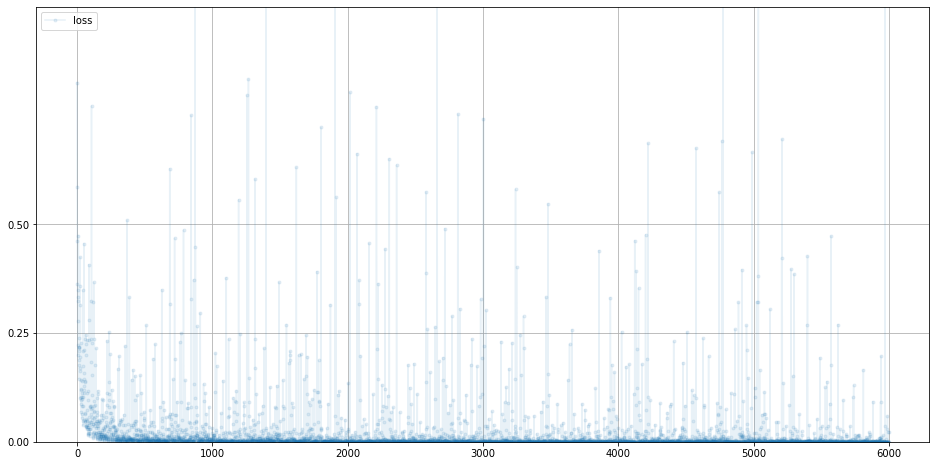

In [9]:
%%time
#训练
C=Classifier()
#使用cuda
C.to(device)

epochs = 1
for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label,image_data_tensor,target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass
C.plot_progress()
    

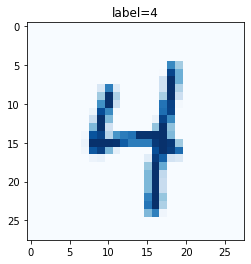

In [10]:
#加载测试集
mnist_test_dataset=MnistDataset(r'D:\py\mnist_data\mnist_test.csv')
#挑选一副图像
record=19
#绘制图像&标签
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

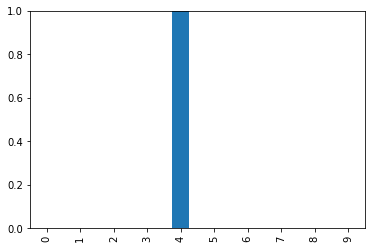

In [12]:
# visualise the answer given by the neural network

image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data.view(1,1,28,28))

# plot output tensor
pandas.DataFrame(output.detach().cpu().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [14]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().cpu().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9740 10000 0.974
